In [2]:
import timeit
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
from collections import namedtuple

# globals
Stats = namedtuple("Stats", "load, std, min, max")

In [2]:
def make_bar_chart(stats, debug=False):
    """
    stats: server load data as a Stats named tuple
    debug: if True, display chart to screen, otherwise savefig
       
    Visualizes request distribution as bar graph.
    """

    server_ids = [x for x in range(servers)]  # x-axis labels
    
    # create figure & subplot    
    fig, ax = plt.subplots(2, sharex=False)
    
    # standard bar graph of data
    ax[0].bar(server_ids, stats.load, color="lightgrey")
    
    # "zoomed" in version (truncated bar graph)
    zoom_min = stats.min * 0.95
    zoom_max = stats.max * 1.02
    ax[1].bar(server_ids, stats.load, color="darkgrey")
    ax[1].set_autoscaley_on(False)
    ax[1].set_ylim([zoom_min, zoom_max])
    
    # threshold line of hypothetical maximum server load
    # threshold = 125
    # ax[1].plot([0, servers-1], [threshold, threshold],
    #            color="red", linestyle=":", label="hypothetical maximum server load")
    # ax[1].legend(loc="upper right")
    
    # set labels on figure
    title = "Load Distribution for {:,} Requests Across {:,} Servers\n".format(requests, servers)
    ax[0].set_title(title)
    ax[0].set_xlabel("Server IDs")
    fig.text(0.04, 0.5, "Requests Processed", ha="center", va="center", rotation="vertical")
    fig.text(0.5, 0.03, "Server IDs", ha="center", va="center")
    ax[1].set_title("A Closer look at the Load Distribution")
    
    # remove decimal from y-axis tick marks
    y1, y2 = ax[0].get_yticks(), ax[1].get_yticks()
    ax[0].set_yticklabels([int(x) for x in y1])
    ax[1].set_yticklabels([int(x) for x in y2])
    
    plt.subplots_adjust(hspace=0.7)
    
    # display or save figure
    if debug:
        plt.show()
    else:
        filename = "foo.png"
        fig.savefig(filename, bbox_inches='tight')
        print("saved chart as:", filename)


def run_simulation_v1(algorithm, args, trials=5):
    """
    algorithm: a load balancing algorithm implementation
               that returns a Stats named tuple
    args: arguments for the algorithm
    trials: how many times the algorithm will run
    
    Usage: run_simulation(some_function, (arg1, arg2), 10)
    
    Run a load balancing simulation for a given number of times
    and generate a graph based on the averaged results.
    """
    
    all_loads = []
    all_stds = []
    avg_load = []

    for i in range(trials):
        stats = algorithm(*args)
        all_loads.append(stats.load)
        all_stds.append(stats.std)

    for x in zip(*all_loads):
        avg = np.average(x)
        avg_load.append(avg)

    avg_std = np.std(avg_load)
    avg_min = min(avg_load)
    avg_max = max(avg_load)

    avg_stats = Stats(avg_load, avg_std, avg_min, avg_max)
    return avg_stats


def run_simulation_v2(algorithm, servers, initial_requests=100, depth=5, factor=2):
    """
    Run a simulation where we return a list of standard deviations
    for different request distributions growing at a rate of `factor`
    over `depth` number of increases.
    
    Ex: If servers=8, initial_requests=100, depth=10, and factor=5,
    this means that the algorithm will run with 8 servers and the 
    following values for requests: [100, 500, 2500, 12500, 62500, 312500,
                                    1562500, 7812500, 39062500, 195312500]
    the std for each run is returned as a list.
    """
    
    stats = []  # std of load distribution
    n = servers
    m = initial_requests

    for d in range(depth):
        result = algorithm(m, n)
        stats.append(result.std)
        m *= factor
        
    return stats


def display_results_v1(stats, trials=1, debug=False):
    print("After taking the average load from each server for {:,} trial(s)".format(trials))
    make_bar_chart(stats, debug=debug)
    print("Standard Deviation:", stats.std)

    
def make_all_bar_charts():
    plt.close('all')
    sim1 = run_simulation_v1(uniform_random, (requests, servers), trials)
    sim2 = run_simulation_v1(round_robin, (requests, servers), trials)
    sim3 = run_simulation_v1(two_choices, (requests, servers), trials)

    sims = [("Random", sim1), ("Round-Robin", sim2), ("Two-Choices", sim3)]

    for x in sims:
        print(x[0])
        display_results_v1(x[1], trials, True)
        print("\n"+"-"*80+"\n")
        

def make_plot(args, amt=3, filename="plot.png", debug=True):
    plt.close('all')
    x_axis = [requests*(factor**x) for x in range(depth)]
    
    sim1 = run_simulation_v2(uniform_random, *args)
    sim2 = run_simulation_v2(round_robin, *args)
    sim3 = run_simulation_v2(two_choices, *args)

    if amt == 3:
        plt.plot(x_axis, sim1, "k--o", label="Random")
    
    plt.plot(x_axis, sim2, "k--s", label="Round Robin")
    plt.plot(x_axis, sim3, "k--^", label="Two-Choices")


    title = "Efficiency of Request Distribution\nas Load Increases Across {} Servers".format(args[0])
    plt.title(title)
    plt.xlabel("Total Requests")
    plt.ylabel("STD of Request Distribution Between Servers")

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    # display or save figure
    if debug:
        plt.show()
    else:
        plt.savefig(filename, bbox_inches='tight')
        print("saved chart as:", filename)

def time_sims(args, amt):
    if amt == 3:
        print("Random:")
        %timeit run_simulation_v2(uniform_random, *args)
    
    print("Round-Robin:")
    %timeit run_simulation_v2(round_robin, *args)
    print("Two-Choices:")
    %timeit run_simulation_v2(two_choices, *args)


In [3]:
def gen_dist(reqs, lam=0.99, uniform=False):
    """
    lam: mean and varience for probability density

    Request arrival on a web server is
    best modeled by a poisson distribution.

    We can use this arrival time as a weight for a
    given request a server must process

    These weights are then used to model our request
    distribution for the simulation enviornment.
    """

    request_arrival_time = nr.poisson(lam, reqs)

    dist = []
    for w in request_arrival_time:
        if uniform:
            request_weight = 1
        else:
            request_weight = (w * 0.1) + 1
        dist.append(request_weight)

    return dist


def initialize(requests, servers):
    dist = gen_dist(requests)
    load = [0] * servers
    return dist, load


def get_stats(load):
    std = np.std(load)
    min_load = min(load)
    max_load = max(load)
    return Stats(load, std, min_load, max_load)


def uniform_random(requests, servers):
    """
    A list represents the load of all servers.
    The index indicates a particular machine and the element at
    a specific index is the amount of requests that machine has processed.

    Example:
       requests: 20
        servers:  0  1  2  3 (total: 4)
           load: [4, 5, 4, 7]
    
    This tells us that in the distribution of 20 requests, 
    server #3 processed seven of them, while server #0 only processed four.
    """
    
    requests = int(requests)
    servers = int(servers)
    
    dist, load = initialize(requests, servers)
    random_balancer = nr.randint(low=0, high=servers, size=requests)
        
    # distribute requests to servers
    for i in range(requests):
        weight = dist[i]
        chosen_server = random_balancer[i]
        load[chosen_server] += weight
        
    return get_stats(load)


def round_robin(requests, servers):
    """
    Each server takes a turn processing the requests.
    """
    
    requests = int(requests)
    servers = int(servers)
    
    dist, load = initialize(requests, servers)
    
    for i in range(requests):
        weight = dist[i]
        chosen_server = i % servers
        load[chosen_server] += weight

    return get_stats(load)



def two_choices(requests, servers):
    """
    The two choices algorithm is quite simple,
    pick two servers at random, and then choose the
    one that is expected to have the least load.
    """
    
    requests = int(requests)
    servers = int(servers)
    
    dist, load = initialize(requests, servers)
    
    # distribute requests to servers
    for i in range(requests):
        # pick two random servers
        choice_one = nr.randint(0, servers)
        choice_two = nr.randint(0, servers)
        
        load_one = load[choice_one]
        load_two = load[choice_two]
        
        if load_one < load_two:
            best_choice = choice_one
        else:
            best_choice = choice_two
    
        weight = dist[i]
        load[best_choice] += weight
        
    return get_stats(load)

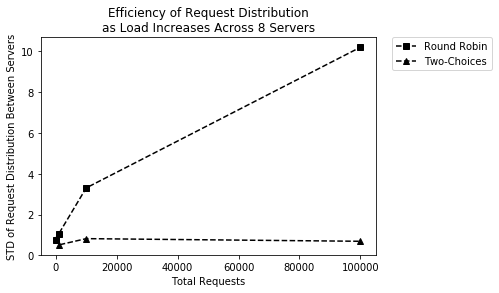

Round-Robin:
416 ms ± 62.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Two-Choices:
765 ms ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
requests = 100
servers = 8  # try with 800
depth = 4 
factor = 10
trials = 1
args = (servers, requests, depth, factor)

#make_all_bar_charts()
make_plot(args, 2, debug=True)

time_sims(args, 2)

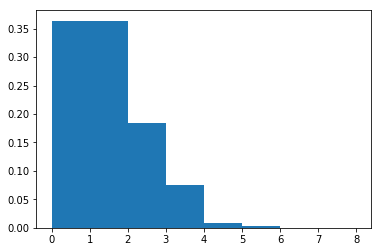

In [5]:
# choosing a lambda value represents the average
# time of a request arrival time
# example: nr.poisson(3, 100) will create a distribution such that
#          for 100 requests, on average each request arrives every 3 seconds

import numpy.random as nr
import matplotlib.pyplot as plt

balls = 1000
bins = 8

s = nr.poisson(0.99, balls)
count, bins, ignored = plt.hist(s, bins, (0, bins))
plt.show()

#plt.axes([0, 0, 10, 1])
#plt.plot(s)
#plt.show()

plt.close('all')